In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import shutup
shutup.please()

import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import functools

# RL 
import gymnasium
import flashbax as fbx

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


Goal - collecting colored shapes (defines task). At inference : change reward -> SFs. If changing position -> novel dynamics

Rewards: [blue square, green triangle, red circle]
Observations: [(x, y) + [0...12] - # collected items], shape = 14

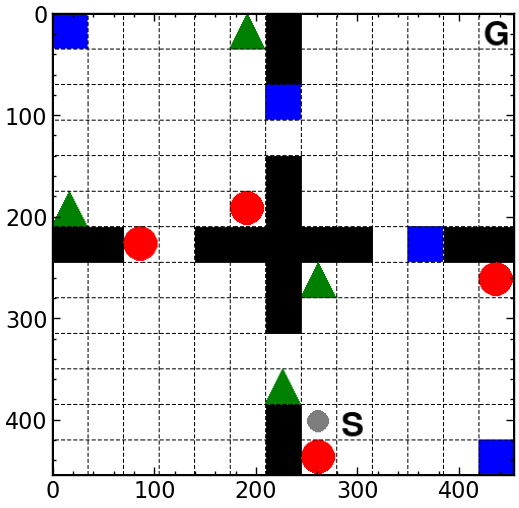

In [2]:
from envs.grid_custom.fourrooms import FourRoom

def rescale_obs_grid(x):
    scaling = (x[0] + x[1]) + 1e-6
    x[0] /= scaling
    x[1] /= scaling
    return x

env = gymnasium.wrappers.TransformObservation(FourRoom(render_mode='rgb_array'), rescale_obs_grid)
#env = FourRoom(render_mode='rgb_array')
obs, info = env.reset(options={"init_state": (12, 5)})
env.step(0)
plt.imshow(env.render())

In [3]:
def collect_grid_explore(env):
    buffer = fbx.make_item_buffer(
        max_length=1_000,
        sample_batch_size=256,
        min_length=100,
        add_batches=False,
        add_sequences=False
    )

    example_timestep = {
        "observations": env.observation_space.sample(),
        "actions": np.atleast_1d(env.action_space.sample()),
        "masks": 0,
        "next_observations": env.observation_space.sample(),
        "rewards": np.array([0.0, 0.0, 0.0])
    }

    state = buffer.init(example_timestep)
    jit_add_buffer = jax.jit(buffer.add)

    for i in range(len(env.state_list)):
        for j in range(4):
            observation, info = env.reset(options={"init_state": env.state_list[i]})
            next_observation, reward, terminated, truncated, info = env.step(j)
            done = terminated # or truncated
            
            observation = next_observation
            new_timestep = {
                "observations": observation,
                "rewards": reward,
                'masks': 1 - done,
                "actions": np.atleast_1d(np.array(j)),
                "next_observations": next_observation
            }
            state = jit_add_buffer(state, new_timestep)

    return buffer, state

explore_buffer, explore_state = collect_grid_explore(env=env)
sampled_data = explore_buffer.sample(explore_state, GLOBAL_KEY).experience

In [ ]:
from agents.fb import ForwardBackwardAgent, get_config

fb_config = get_config()
fb_agent = ForwardBackwardAgent.create(
    seed=42,
    ex_observations=env.observation_space.sample(),
    ex_actions=env.action_space.n,
    config=fb_config
)

2025-02-14 01:39:49.446394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739486389.468608  392120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739486389.475468  392120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
# Define parameters
num_objects = 12  # Number of objects (n_o)
grid_size = 10    # 10x10 grid for RBFs
sigma = 0.1       # Width of Gaussian RBFs

# Generate centers for the RBFs (10x10 grid)
centers = jnp.array([(x, y) for x in jnp.linspace(0, 1, grid_size)
                              for y in jnp.linspace(0, 1, grid_size)])

def rbf_features(position, centers, sigma):
    """
    Compute the RBF features for a given position.
    
    Args:
        position: A tuple (s_x, s_y) representing the agent's position.
        centers: A 2D array of RBF centers.
        sigma: The width of the Gaussian RBFs.
    
    Returns:
        A 1D array of RBF feature activations.
    """
    sx, sy = position
    distances = jnp.sum((jnp.array([sx, sy]) - centers) ** 2, axis=1)
    return jnp.exp(-distances / sigma)

def inventory_features(objects_picked):
    """
    Compute the inventory features.
    
    Args:
        objects_picked: A binary array of shape (n_o,) indicating which objects have been picked.
    
    Returns:
        A 1D array of inventory features.
    """
    return objects_picked  # Directly return the binary vector

def construct_feature_vector(position, objects_picked, centers, sigma):
    """
    Construct the full feature vector phi(s).
    
    Args:
        position: A tuple (s_x, s_y) representing the agent's position.
        objects_picked: A binary array of shape (n_o,) indicating which objects have been picked.
        centers: A 2D array of RBF centers.
        sigma: The width of the Gaussian RBFs.
    
    Returns:
        A 1D array representing the feature vector phi(s).
    """
    phi_p = rbf_features(position, centers, sigma)  # Position features
    phi_i = inventory_features(objects_picked)      # Inventory features
    phi = jnp.concatenate([phi_p, phi_i, jnp.array([1.0])])  # Add bias term
    return phi

# Example usage
key = random.PRNGKey(0)
position = sampled_data['observations'][0, :2]  # Agent's position (s_x, s_y)
objects_picked = random.bernoulli(key, shape=(num_objects,))  # Random binary vector for objects

# Construct the feature vector
feature_vector = construct_feature_vector(position, objects_picked, centers, sigma)
print("Feature vector:", feature_vector)
print("Feature vector shape:", feature_vector.shape)

Feature vector: [1.9304551e-03 2.9738431e-03 3.5788447e-03 3.3646068e-03 2.4711143e-03
 1.4178100e-03 6.3549227e-04 2.2252016e-04 6.0868850e-05 1.3007298e-05
 9.0337340e-03 1.3916355e-02 1.6747510e-02 1.5744973e-02 1.1563797e-02
 6.6347695e-03 2.9738417e-03 1.0413016e-03 2.8484085e-04 6.0868850e-05
 3.3024903e-02 5.0874446e-02 6.1224394e-02 5.7559390e-02 4.2274129e-02
 2.4254927e-02 1.0871566e-02 3.8067186e-03 1.0413016e-03 2.2252016e-04
 9.4315432e-02 1.4529170e-01 1.7485003e-01 1.6438319e-01 1.2073020e-01
 6.9269344e-02 3.1047963e-02 1.0871566e-02 2.9738417e-03 6.3549227e-04
 2.1042174e-01 3.2415199e-01 3.9009789e-01 3.6674589e-01 2.6935422e-01
 1.5454288e-01 6.9269344e-02 2.4254927e-02 6.6347695e-03 1.4178100e-03
 3.6674595e-01 5.6496739e-01 6.7990506e-01 6.3920468e-01 4.6945983e-01
 2.6935413e-01 1.2073014e-01 4.2274129e-02 1.1563797e-02 2.4711143e-03
 4.9935192e-01 7.6924521e-01 9.2574143e-01 8.7032479e-01 6.3920456e-01
 3.6674577e-01 1.6438308e-01 5.7559375e-02 1.5744973e-02 3.36

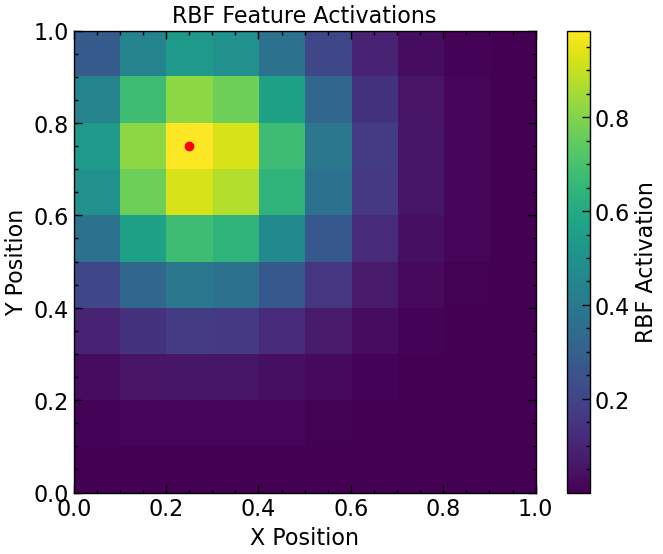

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Compute RBF features for the given position
rbf_activations = rbf_features(position, centers, sigma)

# Reshape the RBF activations into a 10x10 grid
rbf_grid = rbf_activations.reshape((grid_size, grid_size))

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(rbf_grid, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='RBF Activation')
plt.scatter(position[1], position[0], color='red')  # Mark the agent's position
plt.title('RBF Feature Activations')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

<Axes: >

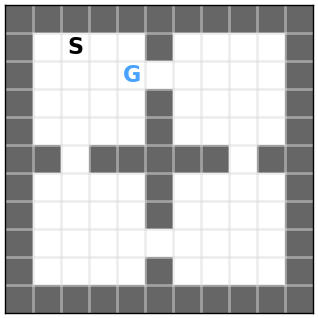

In [2]:
from envs.grid_custom.darkroom import DarkRoom

env = DarkRoom(grid_name='fourroom', terminate_on_goal=True) # use False during data collection
start_state, info = env.reset()
env.plot_grid()

[1 2]
[-1.  0.]
[1 2]
[1 2]


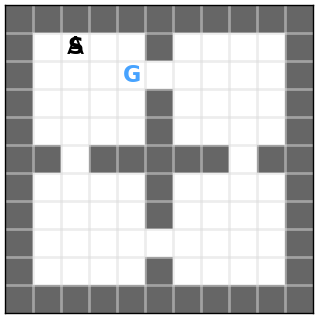

In [3]:
env.step(1)
env.render()